# TPHLCT 1階の導関数を相殺する

In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

# 画像の用意
# AIRPLANE = ImageLoader("../Mono/airplane512.bmp")
# BARBARA = ImageLoader("../Mono/BARBARA.bmp")
# BOAT = ImageLoader("../Mono/BOAT.bmp")
# BRIDGE = ImageLoader("../Mono/BRIDGE.bmp")
# BUILDING = ImageLoader("../Mono/Building.bmp")
# CAMERAMAN = ImageLoader("../Mono/Cameraman.bmp")
# GIRL = ImageLoader("../Mono/girl.bmp")
# LAX = ImageLoader("../Mono/LAX.bmp")
# LENNA = ImageLoader("../Mono/lenna512.bmp")
# LIGHTHOUSE = ImageLoader("../Mono/Lighthouse.bmp")
# SIDBAtitle = ImageLoader("../Mono/SIDBAtitle256.bmp")
# TEXT = ImageLoader("../Mono/Text.bmp")
# WOMAN = ImageLoader("../Mono/WOMAN.bmp")

MONO_DIR_PATH = "../../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")

# Images = np.array(
#     [
#         AIRPLANE,
#         BARBARA,
#         BOAT,
#         BRIDGE,
#         BUILDING,
#         CAMERAMAN,
#         GIRL,
#         LAX,
#         LENNA,
#         LIGHTHOUSE,
#         SIDBAtitle,
#         TEXT,
#         WOMAN,
#     ]
# )

N = 8

# DCT

## 基底関数

$$
\phi_k[i] = \begin{cases}
\cfrac{1}{\sqrt{N}}  \quad \quad \quad (k=0) \\
\sqrt{\cfrac{2}{N}} \cos \left({\cfrac{\pi}{2N}(2i+1)k}\right) \quad  (k=1,2,...,N-1) 
\end{cases}
$$

In [2]:
class DCT:
    def __init__(self, N):
        self.N = N  # データ数
        # 1次元DCTの基底ベクトルの生成
        self.phi_1d = np.array([self.phi(i) for i in range(self.N)])
        # 2次元DCTの基底ベクトルの格納
        self.phi_2d = np.zeros((N, N))

    def phi(self, k):
        """ 離散コサイン変換(DCT)の基底関数 """
        # DCT-II
        if k == 0:
            return np.ones(self.N) / np.sqrt(self.N)
        else:
            return np.sqrt(2.0 / self.N) * np.cos(
                (k * np.pi / (2 * self.N)) * (np.arange(self.N) * 2 + 1)
            )

    def dct(self, data):
        """ 1次元離散コサイン変換を行う """
        return self.phi_1d.dot(data)

    def idct(self, c):
        """ 1次元離散コサイン逆変換を行う """
        return np.sum(self.phi_1d.T * c, axis=1)

    def get_dct2_phi(self, y, x):
        """ 2次元離散コサイン変換の基底を返す """
        phi_x, phi_y = np.meshgrid(self.phi_1d[x], self.phi_1d[y])
        return phi_x * phi_y

    def get_dct2(self, y, x, data):
        """ i,jの2次元DCT係数を返す """
        phi_2d_phi = np.zeros((self.N, self.N))
        phi_2d_phi = self.get_dct2_phi(y, x)
        return np.sum(np.sum(phi_2d_phi * data))

    def dct2(self, data):
        """ 2次元離散コサイン変換を行う """
        for y in range(self.N):
            for x in range(self.N):
                self.phi_2d[y, x] = self.get_dct2(y, x, data)

        return self.phi_2d

    def idct2(self, c):
        """ 2次元離散コサイン逆変換を行う """
        idct2_data = np.zeros((self.N, self.N))
        phi_2d_phi = np.zeros((self.N, self.N))
        for y in range(self.N):
            for x in range(self.N):
                phi_2d_phi = self.get_dct2_phi(y, x)
                idct2_data += c[y,x] * phi_2d_phi

        return idct2_data

# 係数の計算

$\alpha_k, \beta_k$を計算する。  
1階導関数を相殺するような予測関数は 
$$
u(x)=-\frac{f_x(0)}{2}(1-x^2)+\frac{f_x(1)}{2}x^2
$$
で与えられる。  

そのとき、   
$$\alpha_k = -\sqrt{\frac{2}{N}}\sum_{\ell=0}^{N-1}\frac{(1-x_\ell)^2}{2}\cos(\pi k x_\ell)$$

$$\beta_k = \sqrt{\frac{2}{N}}\sum_{\ell=0}^{N-1}\frac{x_\ell^2}{2}\cos(\pi k x_\ell)$$  

findfont: Font family ['Source Han Sans JP'] not found. Falling back to DejaVu Sans.


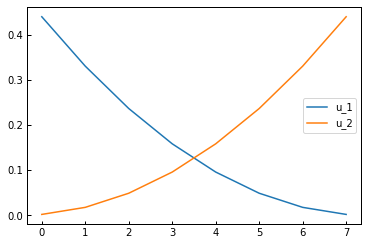

In [3]:
sampling_x = (0.5 + np.arange(N)) / N
u_1 = (1 - sampling_x) ** 2 / 2
u_2 = (sampling_x) ** 2 / 2
plt.plot(u_1, label="u_1")
plt.plot(u_2, label="u_2")
plt.legend()

In [4]:
alpha = scipy.fftpack.dct(u_2,norm="ortho")
alpha

array([ 0.4695631 , -0.40264519,  0.09857256, -0.04209093,  0.02209709,
       -0.01255643,  0.00700534, -0.0031689 ])

In [5]:
beta = -scipy.fftpack.dct(u_1,norm="ortho") 
beta

array([-0.4695631 , -0.40264519, -0.09857256, -0.04209093, -0.02209709,
       -0.01255643, -0.00700534, -0.0031689 ])

# DCTして残差を計算

$
V_k = F_k - U_k\\
V_k = F_k -\alpha f_x(0) -\beta f_x(1)\\
f_x(0) \simeq \frac{F_0}{\sqrt{N}}-\frac{F_0^L}{\sqrt{N}}\\
f_x(1) \simeq \frac{F_0^R}{\sqrt{N}}-\frac{F_0}{\sqrt{N}}\\
V_k = F_k - \frac{\alpha}{\sqrt{N}}(F_0^R-F_0)-\frac{\beta_k}{\sqrt{N}}(F_0-F_0^L)
$

## DCT

2次元入力信号を垂直方向の一次元信号が水平方向に並列に並んでいるものとみなし、各列において8画素単位の1次元DCTを適用する

In [6]:
IMG = MILKDROP

In [7]:
Fk = np.zeros(IMG.img.shape)

### 縦方向

In [8]:
for row in range(IMG.img.shape[0] // 8):
    for col in range(IMG.img.shape[1]):
        eight_points = IMG.img[8 * row : 8 * (row + 1), col]
        c = scipy.fftpack.dct(eight_points,norm="ortho")
        Fk[8 * row : 8 * (row + 1), col] = c

### 縦方向の残差

In [9]:
for row in range(Fk.shape[0] // 8):
    for col in range(Fk.shape[1]):
        F = Fk[8 * row : 8 * (row + 1), col]

        F_0_r = 0
        if row is not Fk.shape[0] // 8 - 1:
            F_0_r = Fk[8 * (row + 1), col]

        F_0_l = 0
        if row is not 0:
            F_0_l = Fk[8 * (row - 1), col]

        # 残差
        F_0 = F[0]
        F = F - alpha * (F_0_r - F_0) / np.sqrt(N) - beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[0] = F_0
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[8 * row : 8 * (row + 1), col] = F

### 横方向

In [10]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 8):
        eight_points = Fk[row, 8 * col : 8 * (col + 1)]
        c = scipy.fftpack.dct(eight_points,norm="ortho")
        Fk[row, 8 * col : 8 * (col + 1)] = c

### 横方向の残差

In [11]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 8):
        F = Fk[row, 8 * col : 8 * (col + 1)]

        F_0_r = 0
        if col is not Fk.shape[1] // 8 - 1:
            F_0_r = Fk[row, 8 * (col + 1)]

        F_0_l = 0
        if col is not 0:
            F_0_l = Fk[row, 8 * (col - 1)]

        # 残差
        F_0 = F[0]
        F = F - alpha * (F_0_r - F_0) / np.sqrt(N) - beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[0] = F_0
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[row, 8 * col : 8 * (col + 1)] = F

# 係数の確保

In [12]:
Fk_Ori = np.copy(Fk)

## 低域3成分 (0,1)(1,0)(1,1)の絶対値の和

In [13]:
low_3_value = 0
others_value = 0
DC = 0

In [14]:
for row in range(Fk.shape[0] // 8):
    for col in range(Fk.shape[1] // 8):
        block = Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        DC += np.abs(block[0,0])
        low_3_value += np.abs(block[0, 1]) + np.abs(block[1, 0]) + np.abs(block[1, 1])
        others_value += (
            np.sum(np.sum(np.abs(block)))
            - np.abs(block[0, 0])
            - np.abs(block[0, 1])
            - np.abs(block[1, 0])
            - np.abs(block[1, 1])
        )

In [15]:
low_3_value

207060.72159744013

In [16]:
others_value

738092.4748966075

In [17]:
np.sum(np.sum(np.abs(Fk))) - DC - low_3_value

738092.4748966075

In [18]:
# np.savetxt('lena_tphlct.csv', Fk, delimiter=',')

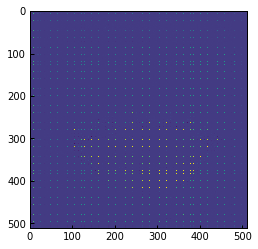

In [19]:
plt.imshow(Fk)

# 逆変換

$
F_k = V_k + \frac{\alpha}{\sqrt{N}}(F_0^R-F_0)+\frac{\beta_k}{\sqrt{N}}(F_0-F_0^L)
$

In [20]:
# recover = np.zeros(IMG.img.shape).astype("uint8")
recover = np.zeros(IMG.img.shape)

## 横方向

In [21]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 8):
        F = Fk[row, 8 * col : 8 * col + 8]

        F_0_r = 0
        if col is not Fk.shape[1] // 8 - 1:
            F_0_r = Fk[row, 8 * (col + 1)]

        F_0_l = 0
        if col is not 0:
            F_0_l = Fk[row, 8 * (col - 1)]

        # 残差
        F_0 = F[0]
        F = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[0] = F_0
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[row, 8 * col : 8 * col + 8] = F

In [22]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 8):
        F = Fk[row, 8 * col : 8 * col + 8]
        data = scipy.fftpack.idct(F,norm="ortho")
        # Fkに代入した後、縦方向に対して処理
        Fk[row, 8 * col : 8 * col + 8] = data
        # 復元画像
#         recover[row, 8 * col : 8 * col + 8] = data

## 縦方向

In [23]:
for row in range(Fk.shape[0] // 8):
    for col in range(Fk.shape[1]):
        F = Fk[8 * row : 8 * row + 8, col]

        F_0_r = 0
        if row is not Fk.shape[0] // 8 - 1:
            F_0_r = Fk[8 * (row + 1), col]

        F_0_l = 0
        if row is not 0:
            F_0_l = Fk[8 * (row - 1), col]

        # 残差
        F_0 = F[0]
        F = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[0] = F_0
        # F_0 F_1 F_2 F_3 F_4 F_5 F_6 F_7
        Fk[8 * row : 8 * row + 8, col] = F

In [24]:
for row in range(Fk.shape[0] // 8):
    for col in range(Fk.shape[1]):
        F = Fk[8 * row : 8 * (row + 1), col]
        data = scipy.fftpack.idct(F,norm="ortho")
        # 復元画像
        recover[8 * row : 8 * (row + 1), col] = data
        # FKに代入した後、横方向に対して処理
#         Fk[8 * row : 8 * (row + 1), col] = data

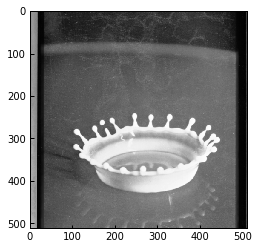

In [25]:
plt.imshow(np.round(recover),cmap="gray")

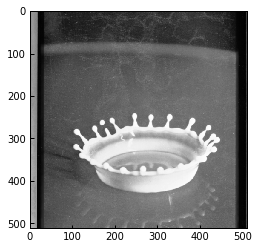

In [26]:
plt.imshow(IMG.img, cmap="gray")

In [27]:
recover[0,0:10]

array([ 21., 135., 140., 143., 141., 142., 146., 149., 149., 146.])

In [28]:
IMG.img[0,0:10]

array([ 21, 135, 140, 143, 141, 142, 146, 149, 149, 146], dtype=uint8)

ちゃんと復元できた

# 量子化テーブル

In [29]:
Q50_Luminance = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

In [30]:
Q = 30
Q_Luminance = np.copy(Q50_Luminance)
if Q < 50:
    Q_Luminance = Q_Luminance * 50 / Q
    Q_Luminance = np.where(Q_Luminance > 255, 255, Q_Luminance)
else:
    Q_Luminance = (100 - Q) * Q50_Luminance / 50
    Q_Luminance = np.where(Q_Luminance < 1, 1, Q_Luminance)

# 量子化

In [31]:
Fk = np.copy(Fk_Ori)

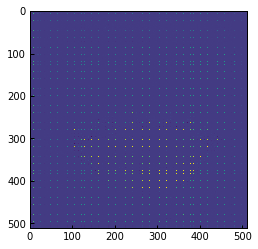

In [32]:
plt.imshow(Fk)

In [33]:
Q_Fk = np.zeros(Fk.shape)

In [34]:
for row in range(IMG.img.shape[0] // 8):
    for col in range(IMG.img.shape[1] // 8):
        block = Fk[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        # 量子化
        block = np.round(block / Q_Luminance)
        # 逆量子化
        block = block * Q_Luminance
        Q_Fk[row * 8 : (row+1)*8, col * 8 : (col+1)*8] = block

# 逆変換

In [35]:
Fk = np.copy(Q_Fk)

In [36]:
Q_recover = np.zeros(Q_Fk.shape)

## 横方向

In [37]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 8):
        F = Fk[row, 8 * col : 8 * col + 8]

        F_0_r = 0
        if col is not Fk.shape[1] // 8 - 1:
            F_0_r = Fk[row, 8 * (col + 1)]

        F_0_l = 0
        if col is not 0:
            F_0_l = Fk[row, 8 * (col - 1)]

        # 残差
        F_0 = F[0]
        F = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[0] = F_0
        # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
        Fk[row, 8 * col : 8 * col + 8] = F

In [38]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // 8):
        F = Fk[row, 8 * col : 8 * col + 8]
        data = scipy.fftpack.idct(F,norm="ortho")
        # Fkに代入した後、縦方向に対して処理
        Fk[row, 8 * col : 8 * col + 8] = data
        # 復元画像
#         recover[row, 8 * col : 8 * col + 8] = data

## 縦方向

In [39]:
for row in range(Fk.shape[0] // 8):
    for col in range(Fk.shape[1]):
        F = Fk[8 * row : 8 * row + 8, col]

        F_0_r = 0
        if row is not Fk.shape[0] // 8 - 1:
            F_0_r = Fk[8 * (row + 1), col]

        F_0_l = 0
        if row is not 0:
            F_0_l = Fk[8 * (row - 1), col]

        # 残差
        F_0 = F[0]
        F = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
        # F_0は残す
        F[0] = F_0
        # F_0 F_1 F_2 F_3 F_4 F_5 F_6 F_7
        Fk[8 * row : 8 * row + 8, col] = F

In [40]:
for row in range(Fk.shape[0] // 8):
    for col in range(Fk.shape[1]):
        F = Fk[8 * row : 8 * (row + 1), col]
        data = scipy.fftpack.idct(F,norm="ortho")
        # 復元画像
        Q_recover[8 * row : 8 * (row + 1), col] = data
        # FKに代入した後、横方向に対して処理
#         Fk[8 * row : 8 * (row + 1), col] = data

In [41]:
Q_recover = np.round(Q_recover)

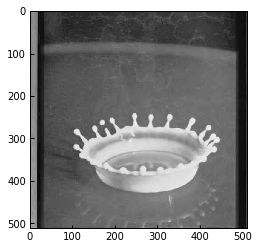

In [42]:
plt.imshow(Q_recover, cmap="gray")
# plt.imsave("TPHLCT1_8x8_LENNA.png",Q_recover,cmap="gray")

# 情報量

$$
S = - \sum ^{255}_{i=0} p_i log_2 p_i
$$

In [43]:
import pandas as pd
qfk = pd.Series(Q_Fk.flatten())
pro = qfk.value_counts() / qfk.value_counts().sum()
pro.head()

-0.000000     0.947838
 20.000000    0.003033
-20.000000    0.002735
 23.333333    0.002472
-23.333333    0.002380
dtype: float64

In [44]:
S = 0
for pi in pro:
    S -= pi * np.log2(pi)
S

0.6272768300709363

# PSNR

$$
PSNR = 10 log_{10} \frac{MAX^2}{MSE}
$$

$$
{MSE = \frac{1}{m \, n} \sum^{m-1}_{i=0} \sum^{n-1}_{j=0} [ I(i,j) - K(i,j) ]^2}
$$
$I(i,j)$は原画像, $K(i,j)$は圧縮画像

In [45]:
MSE = np.sum(np.sum(np.power((IMG.img - Q_recover),2)))/(Q_recover.shape[0] * Q_recover.shape[1])

In [46]:
PSNR = 10 * np.log10(255 * 255 / MSE)

In [47]:
PSNR

36.42087871498229

# MSSIM

In [48]:
ssim(IMG.img,Q_recover.astype(IMG.img.dtype),gaussian_weights=True,sigma=1.5,K1=0.01,K2=0.03)

0.8899409716041654

# MSDS

In [49]:
w_e = 0
e_e = 0
n_e = 0
s_e = 0
nw_e = 0
ne_e = 0
sw_e = 0
se_e = 0
for row in range(Q_recover.shape[0] // 8):
    for col in range(Q_recover.shape[1] // 8):
        f_block = Q_recover[row * 8 : (row + 1) * 8, col * 8 : (col + 1) * 8]
        # w
        if col == 0:
            w_block = np.fliplr(f_block)
        else:
            w_block = Q_recover[row * 8 : (row + 1) * 8, (col - 1) * 8 : col * 8]
        # e
        if col == Q_recover.shape[1] // 8 - 1:
            e_block = np.fliplr(f_block)
        else:
            e_block = Q_recover[row * 8 : (row + 1) * 8, (col + 1) * 8 : (col + 2) * 8]
        # n
        if row == 0:
            n_block = np.flipud(f_block)
        else:
            n_block = Q_recover[(row - 1) * 8 : row * 8, col * 8 : (col + 1) * 8]
        # s
        if row == Q_recover.shape[0] // 8 - 1:
            s_block = np.flipud(f_block)
        else:
            s_block = Q_recover[(row + 1) * 8 : (row + 2) * 8, col * 8 : (col + 1) * 8]

        w_d1 = f_block[:, 0] - w_block[:, 7]
        e_d1 = f_block[:, 7] - e_block[:, 0]
        n_d1 = f_block[0, :] - n_block[7, :]
        s_d1 = f_block[7, :] - s_block[0, :]

        w_d2 = (w_block[:, 7] - w_block[:, 6] + f_block[:, 1] - f_block[:, 0]) / 2
        e_d2 = (e_block[:, 1] - e_block[:, 0] + f_block[:, 7] - f_block[:, 6]) / 2
        n_d2 = (n_block[7, :] - n_block[6, :] + f_block[1, :] - f_block[0, :]) / 2
        s_d2 = (s_block[1, :] - s_block[0, :] + f_block[7, :] - f_block[6, :]) / 2

        w_e += np.sum((w_d1 - w_d2) ** 2 )
        e_e += np.sum((e_d1 - e_d2) ** 2 )
        n_e += np.sum((n_d1 - n_d2) ** 2)
        s_e += np.sum((s_d1 - s_d2) ** 2)
        
        # nw
        if row == 0 or col == 0:
            nw_block = np.flipud(np.fliplr(f_block))
        else:
            nw_block = Q_recover[(row - 1) * 8 : row * 8, (col - 1) * 8 : col * 8]
        # ne
        if row == 0 or col == Q_recover.shape[1] // 8 - 1:
            ne_block = np.flipud(np.fliplr(f_block))
        else:
            ne_block = Q_recover[(row-1) * 8 : row * 8, (col + 1) * 8 : (col + 2) * 8]
        # sw
        if row == Q_recover.shape[0] // 8 -1 or col == 0:
            sw_block = np.flipud(np.fliplr(f_block))
        else:
            sw_block = Q_recover[row * 8 : (row+1) * 8, (col-1) * 8 : col * 8]
        # se
        if  row == Q_recover.shape[0]//8-1 or col == Q_recover.shape[0] // 8 -1:
            se_block = np.flipud(np.fliplr(f_block))
        else:
            se_block = Q_recover[(row + 1) * 8 : (row + 2) * 8, (col+1) * 8 : (col + 2) * 8]

        nw_g1 = f_block[0, 0] - nw_block[7, 7]
        ne_g1 = f_block[0, 7] - ne_block[7, 0]
        sw_g1 = f_block[7, 0] - sw_block[0, 7]
        se_g1 = f_block[7, 7] - se_block[0, 0]

        nw_g2 = (nw_block[7,7] - nw_block[6,6] + f_block[1,1] - f_block[0,0])/2
        ne_g2 = (ne_block[7,0] - ne_block[6,1] + f_block[1,6] - f_block[0,7])/2
        sw_g2 = (sw_block[0,7] - nw_block[1,6] + f_block[6,1] - f_block[7,0])/2
        se_g2 = (nw_block[0,0] - nw_block[1,1] + f_block[6,6] - f_block[7,7])/2

        nw_e += (nw_g1 - nw_g2) ** 2 
        ne_e += (ne_g1 - ne_g2) ** 2 
        sw_e += (sw_g1 - sw_g2) ** 2 
        se_e += (se_g1 - se_g2) ** 2 

MSDSt = (w_e + e_e + n_e + s_e + nw_e + ne_e + sw_e + se_e)/ ((512/8)**2)
MSDS1 = (w_e + e_e + n_e + s_e)/ ((512/8)**2)
MSDS2 = (nw_e + ne_e + sw_e + se_e)/ ((512/8)**2)

In [50]:
MSDS1

2583.4654541015625

In [51]:
MSDS2

1187.1521606445312

In [52]:
arr = np.array([0,1,2,3])
a = arr[0:2]

In [53]:
a

array([0, 1])

In [54]:
arr += 1

In [55]:
arr

array([1, 2, 3, 4])

In [56]:
1 - arr

array([ 0, -1, -2, -3])